# Set up

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sb
import re

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding

# List of devices
tf.config.list_physical_devices()

# Plot model function
# keras.utils.plot_model(model, show_shapes = True)

# Model loading function
# model = keras.models.load_model('model.keras', compile = False)
# model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.summary()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load and analysis of dataset

In [4]:
#df = pd.read_csv(f'{drive_path}/IMDB_Dataset.csv')
df = pd.read_csv('IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming te...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
def dataset_lookup(df):
    print('Dataset info:')
    print(df.info())
    print()
    print('Dataset description:')
    print(df.describe())
    print()
    print('Amount of duplicates:')
    duplicates_amount = df.duplicated().sum()
    print(duplicates_amount)
    if (duplicates_amount > 0):
        print('Duplicates:')
        print(df[df.duplicated()])
    print()
    print('Amount of missing values:')
    print(df.isna().sum(axis = 0))

dataset_lookup(df)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Dataset description:
                                                   review sentiment
count                                               50000     50000
unique                                              49581         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

Amount of duplicates:
419
Duplicates:
                                                  review sentiment
3537   Quite what the producers of this appalling ada...  negative
3769   My favourite police series of all time turns t...  positive
4391   Beautiful film, pure Cassavetes style. Gena Ro...  positive
6352  

In [5]:
def rebuild_index_in_dataset(df):
    return df.reset_index().drop(columns = ['index'])

df.drop_duplicates(inplace = True)
df = rebuild_index_in_dataset(df)
print(f'Duplicates: {df.duplicated().sum()}')
df

Duplicates: 0


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming te...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49576,I thought this movie did a down right good job...,positive
49577,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49578,I am a Catholic taught in parochial elementary...,negative
49579,I'm going to have to disagree with the previou...,negative


In [6]:
num_of_classes = len(df['sentiment'].unique())
print(f'Number of classes: {num_of_classes}')

Number of classes: 2


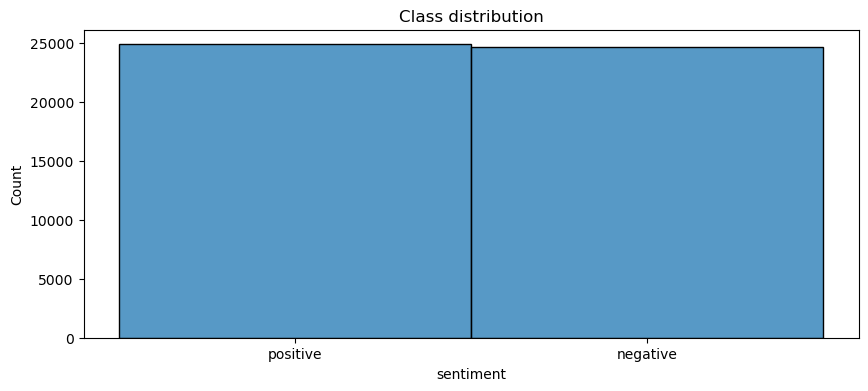

In [ ]:
def show_class_distribution(y, encoder = None):
    plt.figure(figsize = (10, 4))
    plt.title('Class distribution')
    if encoder != None:
        sb.histplot(encoder.inverse_transform(y), discrete = True)
    else:
        sb.histplot(y, discrete = True)
    plt.show()

show_class_distribution(df.sentiment)

Min. length: 4
Max. length: 2459
Avg. length: 229.05988180956416


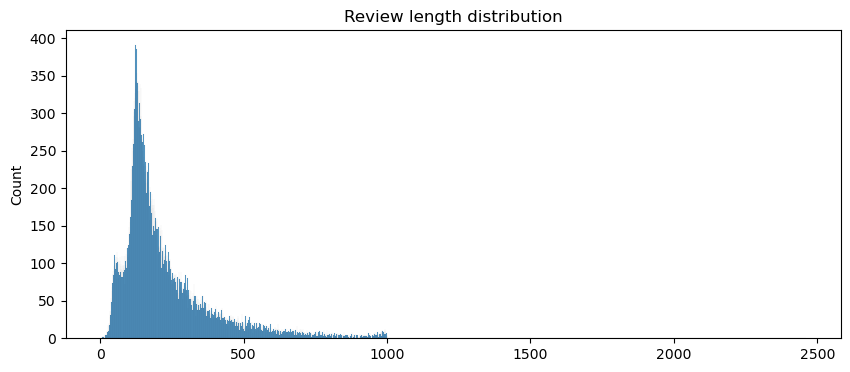

In [ ]:
min_review_length = len(df.review[0].split())
max_review_length = len(df.review[0].split())
lengths = []

for review in df.review:
    review_length = len(review.split())
    lengths.append(review_length)
    if review_length < min_review_length:
        min_review_length = review_length
    if review_length > max_review_length:
        max_review_length = review_length

print(f'Min. length: {min_review_length}')
print(f'Max. length: {max_review_length}')
print(f'Avg. length: {np.average(lengths)}')
plt.figure(figsize = (10, 4))
plt.title('Review length distribution')
sb.histplot(lengths, discrete = True)
plt.show()

# Preprocessing

## Label encoding

In [7]:
df_enc = df.copy()
label_encoder = LabelEncoder()
df_enc['sentiment'] = label_encoder.fit_transform(df_enc['sentiment'])
df_enc['review'] = df_enc['review'].apply(lambda x: x.lower())
df_enc['review'] = df_enc['review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
df_enc

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49576,i thought this movie did a down right good job...,1
49577,bad plot bad dialogue bad acting idiotic direc...,0
49578,i am a catholic taught in parochial elementary...,0
49579,im going to have to disagree with the previous...,0


## String vectorization

In [8]:
reviews_splitted = df_enc['review'].str.split()
reviews_splitted

0        [one, of, the, other, reviewers, has, mentione...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, this, was, a, wonderful, way, to,...
3        [basically, theres, a, family, where, a, littl...
4        [petter, matteis, love, in, the, time, of, mon...
                               ...                        
49576    [i, thought, this, movie, did, a, down, right,...
49577    [bad, plot, bad, dialogue, bad, acting, idioti...
49578    [i, am, a, catholic, taught, in, parochial, el...
49579    [im, going, to, have, to, disagree, with, the,...
49580    [no, one, expects, the, star, trek, movies, to...
Name: review, Length: 49581, dtype: object

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_splitted)
encoded_reviews = tokenizer.texts_to_sequences(reviews_splitted)
max_length = 100
padded_reviews = pad_sequences(encoded_reviews, padding = 'post', maxlen = max_length)

vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')
print(f'Padded sequences shape: {padded_reviews.shape}')
padded_reviews

Vocabulary size: 168063
Padded sequences shape: (49581, 100)


array([[   13,    36,  1578, ...,   121,  4006,   500],
       [13370,   787,  9977, ...,  1911,    69,   221],
       [    9,   192,     8, ...,    63,    14,   331],
       ...,
       [ 1030,   226,    25, ..., 22785,     2,  5900],
       [    5,    68,   133, ...,    67,   711,    41],
       [    1,   113,   678, ...,   786,    10,    16]])

# Dataset split

In [12]:
from sklearn.model_selection import train_test_split

x = padded_reviews
y = pd.get_dummies(df_enc['sentiment']).to_numpy()

x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.1, random_state = 42)

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (33466, 100)
y train: (33466, 2)

x test: (12396, 100)
y test: (12396, 2)

x validation: (3719, 100)
y validation: (3719, 2)


# NN with LSTM layers

In [13]:
def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [26]:
dimension = 32
LSTM
model = Sequential(
[
    Embedding(vocab_size, dimension, input_length = x.shape[1]),
    SpatialDropout1D(0.5),
    LSTM(64, return_sequences = True, dropout = 0.5),
    LSTM(32, dropout = 0.5),
    Dense(16, activation = 'relu'),
    Dense(num_of_classes, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           5378016   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 100, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 100, 64)           24832     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 2)                 34        
                                                      

In [27]:
epochs = 15
batch_size = 32
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_validation, y_validation),
    epochs = epochs,
    batch_size = batch_size)

scores = model.evaluate(x_test, y_test, verbose = 0)
print(f'Scores: {model.metrics_names[0]} of {scores[0]:.3f}; {model.metrics_names[1]} of {scores[1]:.3f}')

Epoch 1/15
1046/1046 [==============================] - 36s 30ms/step - loss: 0.4841 - accuracy: 0.7487 - val_loss: 0.3298 - val_accuracy: 0.8613
Epoch 2/15
1046/1046 [==============================] - 31s 30ms/step - loss: 0.3047 - accuracy: 0.8747 - val_loss: 0.3244 - val_accuracy: 0.8602
Epoch 3/15
1046/1046 [==============================] - 31s 30ms/step - loss: 0.2445 - accuracy: 0.9027 - val_loss: 0.3342 - val_accuracy: 0.8543
Epoch 4/15
1046/1046 [==============================] - 31s 30ms/step - loss: 0.2000 - accuracy: 0.9242 - val_loss: 0.3332 - val_accuracy: 0.8526
Epoch 5/15
1046/1046 [==============================] - 31s 30ms/step - loss: 0.1741 - accuracy: 0.9366 - val_loss: 0.3767 - val_accuracy: 0.8537
Epoch 6/15
1046/1046 [==============================] - 32s 30ms/step - loss: 0.1500 - accuracy: 0.9443 - val_loss: 0.3564 - val_accuracy: 0.8561
Epoch 7/15
1046/1046 [==============================] - 31s 30ms/step - loss: 0.1345 - accuracy: 0.9500 - val_loss: 0.3754 -

<Figure size 700x600 with 0 Axes>

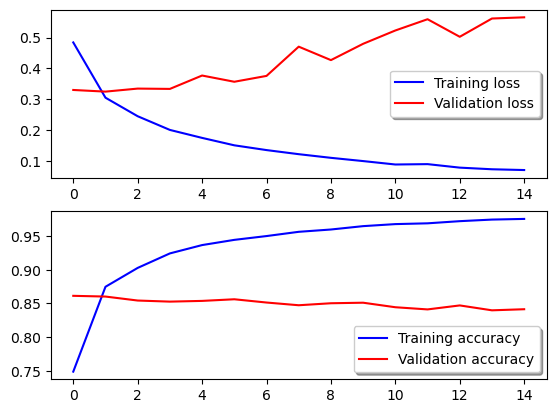

              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      6164
    positive       0.84      0.86      0.85      6232

    accuracy                           0.84     12396
   macro avg       0.85      0.84      0.84     12396
weighted avg       0.85      0.84      0.84     12396



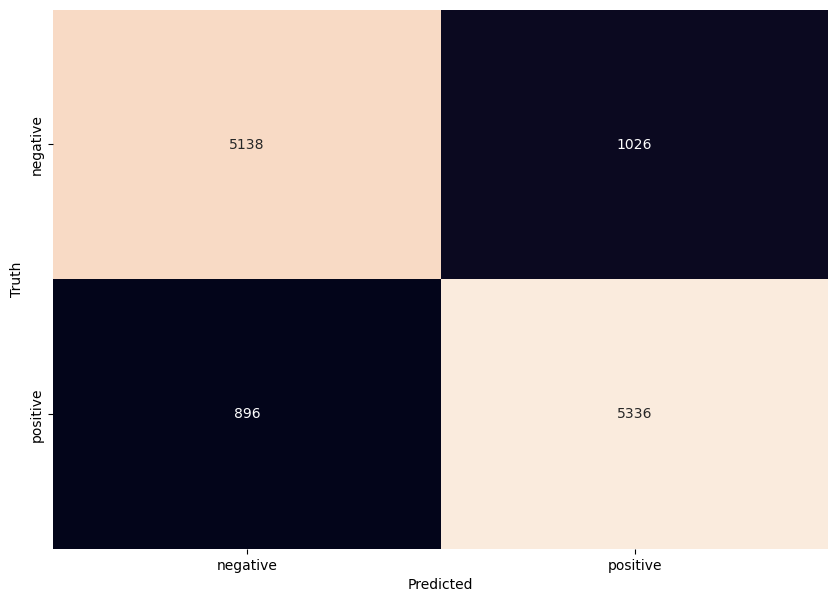

In [28]:
show_training_history(history.history, metrics = ['loss', 'accuracy'], metric_names = ['loss', 'accuracy'])
y_pred = np.argmax(model.predict(x_test), axis = 1)
y_test_argmax = np.argmax(y_test, axis = 1)
print(classification_report(
    label_encoder.inverse_transform(y_test_argmax),
    label_encoder.inverse_transform(y_pred)))
show_confusion_matrix(y_test_argmax, y_pred, list(label_encoder.classes_))

# Test

## Test of predictions

In [70]:
def test_review(model, review_text, tokenizer, max_length, label_encoder):
    review_text = re.sub('[^a-zA-z0-9\s]', '', review_text.lower())
    review_df = pd.DataFrame([review_text], columns = ['review'])
    review_split = review_df['review'].str.split()
    review_seq = tokenizer.texts_to_sequences(review_split)
    review_pad = pad_sequences(review_seq, padding = 'post', maxlen = max_length)
    prediction = np.argmax(model.predict_on_batch(review_pad), axis = 1)
    return label_encoder.inverse_transform(prediction)[0]

n = 10
review_text = df.review.iloc[n]
review_sentiment = df.sentiment.iloc[n]
print(review_text)
print(f'Original sentiment: {review_sentiment}')
print(f'Predicted sentiment: {test_review(model, review_text, tokenizer, max_length, label_encoder)}')

Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines. At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore. Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest. I imagine this film would appeal to a stoner who is currently partaking. For something similar but better try "Brother from another planet"
Original sentiment: negative
Predicted sentiment: negative


In [72]:
num_of_tests = 20
right_answers = 0
for i in range(0, num_of_tests):
    n = np.random.randint(0, df.shape[0])
    print(f'({n}) ---------------')
    review_text = df.review.iloc[n]
    review_sentiment = df.sentiment.iloc[n]
    print(f'Original review text: "{review_text}"')
    print(f'Original sentiment: {review_sentiment}')
    predicted_sentiment = test_review(model, review_text, tokenizer, max_length, label_encoder)
    print(f'Predicted sentiment: {predicted_sentiment}')
    if predicted_sentiment == review_sentiment:
        right_answers += 1
        print('✅ Right')
    else:
        print('❌ Wrong')
    print()

print(f'Percentage of right answers: {(right_answers / num_of_tests * 100):0.2f}')

(30770) ---------------
Original review text: "I realize why people hate this film. And, I hated Blair Witch Project,so go figure? This is about as staged as it gets & yes they do insult your intelligence by trying to make it seem real.I really liked the madame lalaurie storyline though it's more than likely made up. But, the main reason I like this film, is fake or not when the ghosts start attacking & kidnapping them,I get chill-bumps every time & have to look behind me as it feels like something's there with me.i know it's my imagination, but hey more than half of the drivel that is horror in today's cinemas & DVD's doesn't give me goosebumps,so that makes this a creepy delight.Not for everyone, as skeptics will hate it & not for gorehounds as with a PG-13 rating there is no gore. And, the females are very annoying!You'll wish the ghosts would take them off & experiment on them before it's all said & done. ** out of *****."
Original sentiment: negative
Predicted sentiment: negative


Predicted sentiment: positive
✅ Right

(16230) ---------------
Original review text: "Six for the price of one! So it is a bonanza time for Cinegoers. Isn't it? Here it is not one, not two but all SIX-love stories, an ensemble cast of top stars of bollywood, plus all stories in the genre of your favorite top directors Johar, Bhansali, Chopra et al. You will get to see every damn type of love story that you enjoyed or rather tolerated for years now. So no big deal for you. Do you need anything more than this? No sir, thank you. Why sir? Enough is enough. Please spare us. They signed every top star that they manage to sign, whether required or not, so they end up making a circus of stars, believe it or not. Too crowded Every thing depicted here is exactly how it is prescribed in bollywood textbook of romances. Plus you have to justify the length given to each story, as each has stars. Therefore, it is too long-three hours plus. The gags are filmy. Characters are filmy. Problems, Barriers

Predicted sentiment: negative
✅ Right

(10702) ---------------
Original review text: "I'm a huge fan of Ivan Reitman-I loved Evolution and who didn't like Ghostbusters? From the trailer you already know that Uma's character will get dumped by Luke's.So the build-up is obviously towards the moment when she unleashes her superpowers on him.But the pay-off is just not there.The shark tossing did manage to get a (slight) giggle but once again, it was all in the trailer. No one does breathless quite like Uma and Luke is diet Owen on his good days.If not for Riann Wilson you would sit there with a constipated smile until your cheeks start to cramp.This is a comedy,right?  It's not awful-it just sits there like a stale cracker behind the fridge.This could have been such a brilliant send-up of Superhero movies and Feminism but fails on both counts.Let's see if Jason Reitman can salvage the family name."
Original sentiment: negative
Predicted sentiment: negative
✅ Right

(2740) ---------------


## Showcase of wrong predictions

In [73]:
wrong_answers = 0
max_wrong_answers = 20
n = 0
while wrong_answers < max_wrong_answers:
    if n == df.shape[0]:
        break
    review_text = df.review.iloc[n]
    review_sentiment = df.sentiment.iloc[n]
    predicted_sentiment = test_review(model, review_text, tokenizer, max_length, label_encoder)
    if predicted_sentiment != review_sentiment:
        wrong_answers += 1
        print(f'({n}) ---------------')
        print(f'Original review text: "{review_text}"')
        print(f'Original sentiment: {review_sentiment}')
        print(f'Predicted sentiment: {predicted_sentiment}')
        print('❌ Wrong')
        print()
    n += 1
    
if wrong_answers == 0:
    print('No wrong predictions')

(4) ---------------
Original review text: "Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter.  This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat. The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discer

(147) ---------------
Original review text: "Francis Ford Coppola wrote and directed this stunningly personal story of a married woman's flight from her husband--and the reality that perhaps the youthful glee and excitement of her younger years are behind her. We learn little about this woman's marriage except that she has been feeling her independence slipping away as of late; she's also recently learned she's pregnant, which has further complicated her heart (she doesn't want to be a complacent wifey, despite the maternal way she speaks to her husband over the phone). She meets two men on her journey: a former college football hero who--after an accident during a game--has been left with permanent brain damage, and a sexy, strutting motorcycle cop who has a great deal of trouble in his own life. The clear, clean landscapes (as photographed by the very talented Wilmer Butler) are astutely realized, as are the characters. Shirley Knight, James Caan, and Robert Duvall each deliver stron

(186) ---------------
Original review text: "I haven't read the Anne Rice novel that this movie was based on, but who knows, maybe reading the book is cheaper than renting QUEEN OF THE DAMNED and is probably better for your health. It isn't that this movie is necessarily bad for your health, but a book can be very relaxing and certainly exercises the active part of your brain more so than this movie. You can count the number of pages by Anne Rice that I've read on one hand, but after seeing this movie and Interview with a Vampire, I get the feeling that she writes really good novels. The plots for both movies hint at a whole sea of deep and interwoven vampire history. Still, Stuart Townsend's voice-over narration gets a heck of a lot more annoying than Brad Pitt's vampire narrative ever did, and you can tell that QUEEN OF THE DAMNED's limited production resources barely give enough flesh to the Anne Rice storyline. While Interview decided to go with lace and elegance, QUEEN relies on l

In [75]:
wrong_predictions = 0
n = 0
while n != df.shape[0]:
    review_text = df.review.iloc[n]
    review_sentiment = df.sentiment.iloc[n]
    predicted_sentiment = test_review(model, review_text, tokenizer, max_length, label_encoder)
    if predicted_sentiment != review_sentiment:
        wrong_predictions += 1
    n += 1
print(f'Reviews count: {df.shape[0]}')
print(f'Reviews with wrong predictions: {wrong_predictions}')

Reviews count: 49581
Reviews with wrong predictions: 2667


In [76]:
print(f'Percentage of wrong predictions: {(wrong_predictions / df.shape[0] * 100):0.2f}')

Percentage of wrong predictions: 5.38
